In [1]:
import torch
import datetime
import torchvision
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import requests
import tarfile
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
import zipfile
from PIL import Image, ImageEnhance
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
import random
import torch

import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(4)
import torchvision.transforms as T
import matplotlib.pyplot as plt
t2img = T.ToPILImage()
img2t = T.ToTensor()


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/ADL"

Mounted at /content/drive


In [3]:
# Assuming folder_path is already set to the current working directory
with zipfile.ZipFile(f"{folder_path}/pets_images_final.zip", 'r') as zip_ref:
    zip_ref.extractall("/sample_data")
pretrain_data_path = '/sample_data/pets_images'

In [4]:
# List everything in /tmp
tmp_contents = os.listdir(pretrain_data_path)
print(tmp_contents[:10])
num_workers = os.cpu_count()
num_workers

['image_6506.jpg', 'image_17662.jpg', 'image_25391.jpg', 'image_24794.jpg', 'image_15912.jpg', 'image_5122.jpg', 'image_20870.jpg', 'image_35179.jpg', 'image_6513.jpg', 'image_23807.jpg']


8

In [5]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])

def greyscale(image):
    grayscale_transform = transforms.RandomGrayscale(p=0.2)
    imgs = []
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        greyscale_image = grayscale_transform(im)
        imgs.append(transform(greyscale_image).unsqueeze(0))

    return torch.cat(imgs,0)

def distort_color(image):
    color_jitter = transforms.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.1
    )
    imgs=[]
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        distorted_image = color_jitter(im)
        imgs.append(transform(distorted_image).unsqueeze(0))
    return torch.cat(imgs,0)

def mask_image(image, low_mask_percentage,high_mask_percentage):
    for i in range(image.shape[0]):
        mask_percentage=random.randint(low_mask_percentage,high_mask_percentage)
        rows, cols = image.shape[2:]
        rows_to_mask = int(rows * mask_percentage / 100)
        cols_to_mask = int(cols * mask_percentage / 100)

        top_left_row = random.randint(0, rows - rows_to_mask)
        top_left_col = random.randint(0, cols - cols_to_mask)

        image[i,:, top_left_row:top_left_row + rows_to_mask, top_left_col:top_left_col + cols_to_mask] = 0.5

    return image

distort=transforms.Compose([
    transforms.RandomChoice([lambda x: mask_image(x,5,25),greyscale,distort_color]),
])

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


In [6]:
class CustomImageDataset(Dataset):
    """A custom dataset class for loading preprocessed and saved images."""

    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Path to the directory with preprocessed images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img_name) for img_name in os.listdir(image_dir)
                            if os.path.isfile(os.path.join(image_dir, img_name))]

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to be fetched

        Returns:
            A tuple (image, label), where 'image' is the transformed image tensor,
            and 'label' could be a dummy value if not applicable.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency

        if self.transform:
            image = self.transform(image)

        label = 0
        return image

In [7]:
pre_training_data= CustomImageDataset(pretrain_data_path,transform=transform)
pre_train_dataloader = DataLoader(pre_training_data, batch_size=64, shuffle=True)
len(pre_train_dataloader)

579

In [8]:


class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [9]:
model = UNet(n_channels=3, n_classes=3).float().to(device)



In [10]:
def calculate_supervised_dice_score(predictions, ground_truth):
    """
    Calculate the supervised Dice score for labeled data.

    Args:
        predictions (torch.Tensor): Predictions for labeled data, with shape (batch_size, num_classes, height, width).
        ground_truth (torch.Tensor): Ground truth masks for labeled data, with shape (batch_size, num_classes, height, width).

    Returns:
        torch.Tensor: Supervised Dice score.
    """
    # Convert raw model outputs into probabilities within the range [0, 1] to ensure alignment with the ground truth masks
    predictions = torch.sigmoid(predictions)

    # Smoothing factor to prevent division by zero
    smooth = 1e-5

    # Compute the intersection and union
    intersection = torch.sum(ground_truth * predictions, dim=(1, 2, 3))
    cardinality = torch.sum(ground_truth, dim=(1, 2, 3)) + torch.sum(predictions, dim=(1, 2, 3))

    # Calculate the Dice score
    dice_score = 2 * (intersection + smooth) / (cardinality+ smooth)
    return dice_score.sum()


def pretrain(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    net.train().to(device)
    dl=[]
    for epoch in range(epochs):
        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        print("entered ")
        for i, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs = data.to(device)
            inputs_distorted=distort(inputs).float().to(device)
            outputs = net(inputs_distorted)
            loss = criterion(outputs, inputs)
            loss.backward(retain_graph=False)
            dice+=calculate_supervised_dice_score(outputs,inputs).item()
            optimizer.step()
            running_loss += loss.detach().item()
            total += inputs.size(0)
        trainloss.append(running_loss/total)
        dl.append(dice/total)
        print('[%d, %2d]  MSE loss: %.5f Dice score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ))
    return trainloss , dl


In [11]:
criterion1 =  torch.nn.MSELoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
print(pre_train_dataloader)
mse , dlpt = pretrain(model, criterion1, optimizer, pre_train_dataloader, 20)

Epoch 1
entered 


579it [03:18,  2.92it/s]


[1, 20]  MSE loss: 0.00023 Dice score: 0.52805
Epoch 2
entered 


579it [03:18,  2.92it/s]


[2, 20]  MSE loss: 0.00008 Dice score: 0.53055
Epoch 3
entered 


579it [03:18,  2.92it/s]


[3, 20]  MSE loss: 0.00006 Dice score: 0.53083
Epoch 4
entered 


579it [03:21,  2.88it/s]


[4, 20]  MSE loss: 0.00006 Dice score: 0.53097
Epoch 5
entered 


579it [03:17,  2.94it/s]


[5, 20]  MSE loss: 0.00005 Dice score: 0.53114
Epoch 6
entered 


579it [03:13,  3.00it/s]


[6, 20]  MSE loss: 0.00005 Dice score: 0.53124
Epoch 7
entered 


579it [03:17,  2.94it/s]


[7, 20]  MSE loss: 0.00004 Dice score: 0.53125
Epoch 8
entered 


579it [03:19,  2.91it/s]


[8, 20]  MSE loss: 0.00005 Dice score: 0.53118
Epoch 9
entered 


579it [03:13,  3.00it/s]


[9, 20]  MSE loss: 0.00004 Dice score: 0.53139
Epoch 10
entered 


579it [03:18,  2.92it/s]


[10, 20]  MSE loss: 0.00004 Dice score: 0.53133
Epoch 11
entered 


579it [03:19,  2.91it/s]


[11, 20]  MSE loss: 0.00004 Dice score: 0.53133
Epoch 12
entered 


579it [03:17,  2.93it/s]


[12, 20]  MSE loss: 0.00004 Dice score: 0.53142
Epoch 13
entered 


579it [03:16,  2.94it/s]


[13, 20]  MSE loss: 0.00004 Dice score: 0.53135
Epoch 14
entered 


579it [03:18,  2.92it/s]


[14, 20]  MSE loss: 0.00004 Dice score: 0.53136
Epoch 15
entered 


579it [03:16,  2.95it/s]


[15, 20]  MSE loss: 0.00004 Dice score: 0.53140
Epoch 16
entered 


579it [03:14,  2.98it/s]


[16, 20]  MSE loss: 0.00003 Dice score: 0.53145
Epoch 17
entered 


579it [03:12,  3.00it/s]


[17, 20]  MSE loss: 0.00003 Dice score: 0.53152
Epoch 18
entered 


579it [03:14,  2.97it/s]


[18, 20]  MSE loss: 0.00003 Dice score: 0.53150
Epoch 19
entered 


579it [03:16,  2.95it/s]


[19, 20]  MSE loss: 0.00003 Dice score: 0.53143
Epoch 20
entered 


579it [03:13,  2.99it/s]

[20, 20]  MSE loss: 0.00003 Dice score: 0.53153


In [13]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
inc.conv.conv.0.weight 	 torch.Size([64, 3, 3, 3])
inc.conv.conv.0.bias 	 torch.Size([64])
inc.conv.conv.1.weight 	 torch.Size([64])
inc.conv.conv.1.bias 	 torch.Size([64])
inc.conv.conv.1.running_mean 	 torch.Size([64])
inc.conv.conv.1.running_var 	 torch.Size([64])
inc.conv.conv.1.num_batches_tracked 	 torch.Size([])
inc.conv.conv.3.weight 	 torch.Size([64, 64, 3, 3])
inc.conv.conv.3.bias 	 torch.Size([64])
inc.conv.conv.4.weight 	 torch.Size([64])
inc.conv.conv.4.bias 	 torch.Size([64])
inc.conv.conv.4.running_mean 	 torch.Size([64])
inc.conv.conv.4.running_var 	 torch.Size([64])
inc.conv.conv.4.num_batches_tracked 	 torch.Size([])
down1.mpconv.1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
down1.mpconv.1.conv.0.bias 	 torch.Size([128])
down1.mpconv.1.conv.1.weight 	 torch.Size([128])
down1.mpconv.1.conv.1.bias 	 torch.Size([128])
down1.mpconv.1.conv.1.running_mean 	 torch.Size([128])
down1.mpconv.1.conv.1.running_var 	 torch.Size([128])
down1.mpconv.1.conv.1.num_

In [12]:
model_path = os.path.join(folder_path, f'Unet_pretrained_2.pt')
torch.save(model.state_dict(), model_path)

In [44]:
def tensor_trimap(t):
    x =(t * 255.0 -1.0)
    x = x.to(torch.long)
    x = 255.0 * x + 1.0
    return x

100%|██████████| 791918971/791918971 [00:04<00:00, 174773097.33it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 93586455.00it/s]


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 3, 120, 120]) torch.Size([64, 3, 120, 120])


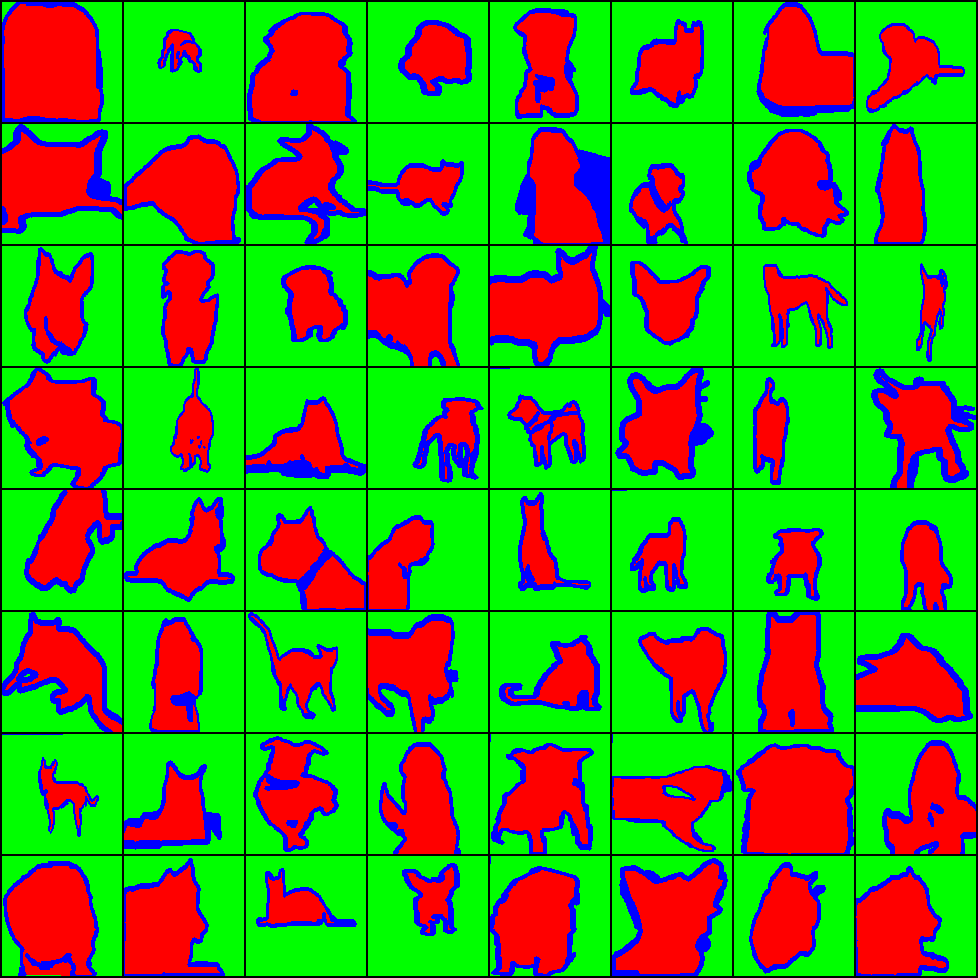

In [13]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])
target_transform=transforms.Compose([
    transforms.Resize((120, 120),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),#transforms.Lambda(tensor_trimap)
    transforms.Lambda(lambda x: torch.nn.functional.one_hot((x*255).long() - 1,3).squeeze(0).permute(2,0,1))
])




training_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='trainval',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True,num_workers=num_workers)




testing_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
test_dataloader = DataLoader(testing_data, batch_size=3, shuffle=False,num_workers=num_workers)

(train_pets_inputs, train_pets_targets) = next(iter(train_dataloader))

print(train_pets_inputs.shape, train_pets_targets.shape)

pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

pets_targets_grid = torchvision.utils.make_grid(train_pets_targets/1.0  , nrow=8)
t2img(pets_targets_grid)

In [16]:
def train(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    dl=[]
    net.train().to(device)
    for epoch in range(epochs):

        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        for  batch_idx, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)
            #outputs = nn.Softmax(dim=1)(outputs)






            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels)


            loss.backward(retain_graph=False)
            dice +=calculate_supervised_dice_score(outputs,labels).item()
            optimizer.step()
            running_loss += loss.detach().item()
            total += inputs.size(0)
        dl.append(dice/total)
        trainloss.append(running_loss/total)
        print('[%d, %2d]  MSE loss: %.5f Dice Score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ))

    return trainloss , dl

tl , dl = train(model, criterion1, optimizer, train_dataloader,50 )

Epoch 1


58it [00:11,  4.92it/s]

[1, 50]  MSE loss: 0.00061 Dice Score: 0.51639
Epoch 2



58it [00:11,  4.96it/s]

[2, 50]  MSE loss: 0.00060 Dice Score: 0.51679
Epoch 3



58it [00:11,  4.93it/s]

[3, 50]  MSE loss: 0.00057 Dice Score: 0.51757
Epoch 4



58it [00:11,  4.96it/s]

[4, 50]  MSE loss: 0.00056 Dice Score: 0.51779
Epoch 5



58it [00:11,  4.92it/s]

[5, 50]  MSE loss: 0.00055 Dice Score: 0.51820
Epoch 6



54it [00:11,  4.80it/s]


KeyboardInterrupt: 

In [22]:
model_path = os.path.join(folder_path, f'Unet_trained_2.pt')
torch.save(model.state_dict(), model_path)

Epoch 1


1223it [00:09, 131.99it/s]


Testing : [1,  1]   Dice Score: 3.98001  


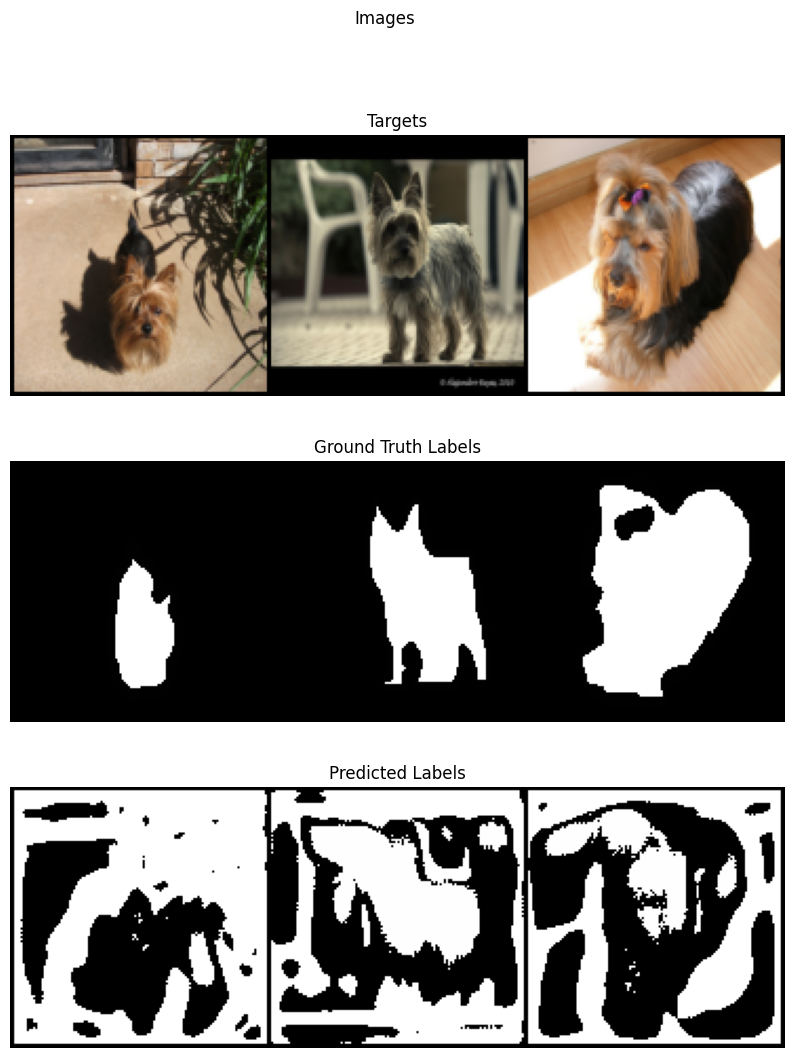

In [24]:
def test(model,  test_data, epochs=20):
    testacc=[]
    model.eval().to(device)
    for epoch in range(epochs):
        print('Epoch',epoch+1)
        dice=0.0
        total=0.0
        with torch.no_grad():
            for batch_idx, data in tqdm(enumerate(test_data, 0)):
                inputs , labels = data
                inputs,labels = inputs.to(device), labels.to(device)
                #print(labels.shape,'label')
                #print(inputs.shape,'input')
                predictions = model(inputs)
                #print(predictions.shape,'pred')
                pred = nn.Softmax(dim=1)(predictions)

                pred_labels = pred.argmax(dim=1)
                pred_labels = pred_labels.unsqueeze(1)
                pred_mask = pred_labels.to(torch.float)
                #pred_mask = predictions.to(torch.float)
                dice+=calculate_supervised_dice_score(predictions,labels).item()
                total += inputs.size(0)







        testacc.append(dice/total)
        print('Testing : [%d, %2d]   Dice Score: %.5f  ' %
                    (epoch + 1,epochs,   testacc[epoch] ))
        if (epoch +1 == 1):
          fig = plt.figure(figsize=(10, 12))
          fig.suptitle('Images', fontsize=12)

          fig.add_subplot(3, 1, 1)
          plt.imshow(t2img(torchvision.utils.make_grid(inputs, nrow=8)))
          plt.axis('off')
          plt.title("Targets")

          fig.add_subplot(3, 1, 2)
          plt.imshow(t2img(torchvision.utils.make_grid(labels.float()/1.0 , nrow=8)))
          plt.axis('off')
          plt.title("Ground Truth Labels")

          fig.add_subplot(3, 1, 3)
          plt.imshow(t2img(torchvision.utils.make_grid(pred_mask.float()/1.0, nrow=8)))
          plt.axis('off')
          plt.title("Predicted Labels")
    return

test(model,  test_dataloader, epochs=1)